In [2]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"   # Delete if you have GPU's available
import tensorflow_datasets as tfds
import tensorflow as tf


In [3]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, image  # Use the image itself as the target label

In [ ]:
import tensorflow_datasets as tfds

# Corrected file path with escaped backslashes and a missing comma
ds1, ds2, ds3 = tfds.load('patch_camelyon',
                         split=['train[:10%]', 'test[:2.5%]', 'validation[:2.5%]'],
                         data_dir=r'C:\Job_og_eksamensbevis\Github\projekter\Projekt_1_Computer_Vision',
                         download=False,
                         shuffle_files=True)

In [5]:
train_dataset       = ds1.map(convert_sample).batch(32)
validation_dataset  = ds3.map(convert_sample).batch(32)
test_dataset        = ds2.map(convert_sample).batch(32)

In [46]:
import tensorflow as tf

# Encoder
inputs = tf.keras.layers.Input(shape=(96, 96, 3))
x = tf.keras.layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
z_mean = tf.keras.layers.Dense(64, name='z_mean')(x)
z_log_var = tf.keras.layers.Dense(64, name='z_log_var')(x)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_var])

# Adjusted Decoder
decoder_input = tf.keras.layers.Dense(24 * 24 * 256, activation='relu')(z)  # Adjust the Dense layer
x = tf.keras.layers.Reshape((24, 24, 256))(decoder_input)
x = tf.keras.layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
x = tf.keras.layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
decoder_output = tf.keras.layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

# Ensure to redefine and recompile the VAE model with these adjustments
vae = tf.keras.models.Model(inputs=inputs, outputs=decoder_output)
vae.compile(optimizer='adam', loss='binary_crossentropy')




In [47]:
# Train the VAE model
vae.fit(train_dataset,
        validation_data=validation_dataset,
        epochs=10)

# Evaluate the model on the test dataset
vae.evaluate(test_dataset)

Epoch 1/10



820/820 [==============================] - 385s 468ms/step - loss: 0.5966 - val_loss: 0.5974
Epoch 2/10
820/820 [==============================] - 395s 482ms/step - loss: 0.5873 - val_loss: 0.5967
Epoch 3/10
820/820 [==============================] - 406s 495ms/step - loss: 0.5870 - val_loss: 0.5983
Epoch 4/10
820/820 [==============================] - 384s 469ms/step - loss: 0.5868 - val_loss: 0.5970
Epoch 5/10
820/820 [==============================] - 387s 472ms/step - loss: 0.5867 - val_loss: 0.5963
Epoch 6/10
820/820 [==============================] - 390s 475ms/step - loss: 0.5863 - val_loss: 0.5959
Epoch 7/10
820/820 [==============================] - 391s 476ms/step - loss: 0.5862 - val_loss: 0.5960
Epoch 8/10
820/820 [==============================] - 395s 482ms/step - loss: 0.5862 - val_loss: 0.5959
Epoch 9/10
820/820 [==============================] - 395s 481ms/step - loss: 0.5861 - val_loss: 0.5960
Epoch 10/10
26/26 [==============================] - 3s 109ms/step - loss: 

0.5877658724784851

In [8]:

# Define the encoder model
latent_dim = 32

encoder_inputs = keras.Input(shape=(96, 96, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)

# Define the mean and variance layers
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Define the sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Define the decoder model
decoder_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16 * 24 * 24, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(decoder_inputs)
x = layers.Reshape((24, 24, 16))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Dropout(0.2)(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

# Define the encoder model
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Define the decoder model
decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")

# Define the VAE model
vae_outputs = decoder(encoder(encoder_inputs)[2])
vae = keras.Model(encoder_inputs, vae_outputs, name="vae")

# Define the loss function
reconstruction_loss = keras.losses.mse(encoder_inputs, vae_outputs)
reconstruction_loss *= 96 * 96 * 3
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_mean(kl_loss)
kl_loss *= -0.5
vae_loss = reconstruction_loss + kl_loss

# Compile the VAE model
vae.add_loss(vae_loss)
vae.compile(optimizer="adam")
vae.summary()

# Set the number of epochs
epochs = 10

# Define the early stopping callback
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Train the VAE model
vae.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=[early_stopping])

# Evaluate the model on the test dataset
loss = vae.evaluate(test_dataset)

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 32),                 610320    ['input_5[0][0]']             
                              (None, 32),                                                         
                              (None, 32)]                                                         
                                                                                                  
 decoder (Functional)        (None, 96, 96, 3)            332739    ['encoder[0][2]']             
                                                                                                

ValueError: in user code:

    File "c:\Users\jeppe\OneDrive\Dokumenter\Privat\SDU\DataScience\anaconda_spyder\envs\ENV_NAME\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\jeppe\OneDrive\Dokumenter\Privat\SDU\DataScience\anaconda_spyder\envs\ENV_NAME\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\jeppe\OneDrive\Dokumenter\Privat\SDU\DataScience\anaconda_spyder\envs\ENV_NAME\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\jeppe\OneDrive\Dokumenter\Privat\SDU\DataScience\anaconda_spyder\envs\ENV_NAME\lib\site-packages\keras\src\engine\training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\jeppe\OneDrive\Dokumenter\Privat\SDU\DataScience\anaconda_spyder\envs\ENV_NAME\lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "c:\Users\jeppe\OneDrive\Dokumenter\Privat\SDU\DataScience\anaconda_spyder\envs\ENV_NAME\lib\site-packages\keras\src\engine\compile_utils.py", line 318, in __call__
        reg_loss = tf.add_n(regularization_losses)

    ValueError: Shapes must be equal rank, but are 0 and 3
    	From merging shape 1 with other shapes. for '{{node AddN}} = AddN[N=3, T=DT_FLOAT](dense_4/kernel/Regularizer/mul, dense_5/kernel/Regularizer/mul, vae/tf.__operators__.add_5/AddV2)' with input shapes: [], [], [?,96,96].


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the encoder model
latent_dim = 32

encoder_inputs = keras.Input(shape=(96, 96, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

# Define the mean and variance layers
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Define the sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Define the decoder model
decoder_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16 * 24 * 24, activation="relu")(decoder_inputs)
x = layers.Reshape((24, 24, 16))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

# Define the encoder model
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Define the decoder model
decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")

# Define the VAE model
vae_outputs = decoder(encoder(encoder_inputs)[2])
vae = keras.Model(encoder_inputs, vae_outputs, name="vae")

# Define the loss function
reconstruction_loss = keras.losses.mse(encoder_inputs, vae_outputs)
reconstruction_loss *= 96 * 96 * 3
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_mean(kl_loss)
kl_loss *= -0.5
vae_loss = reconstruction_loss + kl_loss

# Compile the VAE model
vae.add_loss(vae_loss)
vae.compile(optimizer="adam")
vae.summary()

# Set the number of epochs
epochs = 10

# Define the early stopping callback
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Train the VAE model
vae.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=[early_stopping])

# Evaluate the model on the test dataset
loss = vae.evaluate(test_dataset)

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 32),                 610320    ['input_7[0][0]']             
                              (None, 32),                                                         
                              (None, 32)]                                                         
                                                                                                  
 decoder (Functional)        (None, 96, 96, 3)            332739    ['encoder[0][2]']             
                                                                                                

1/1 [==============================] - 0s 195ms/step


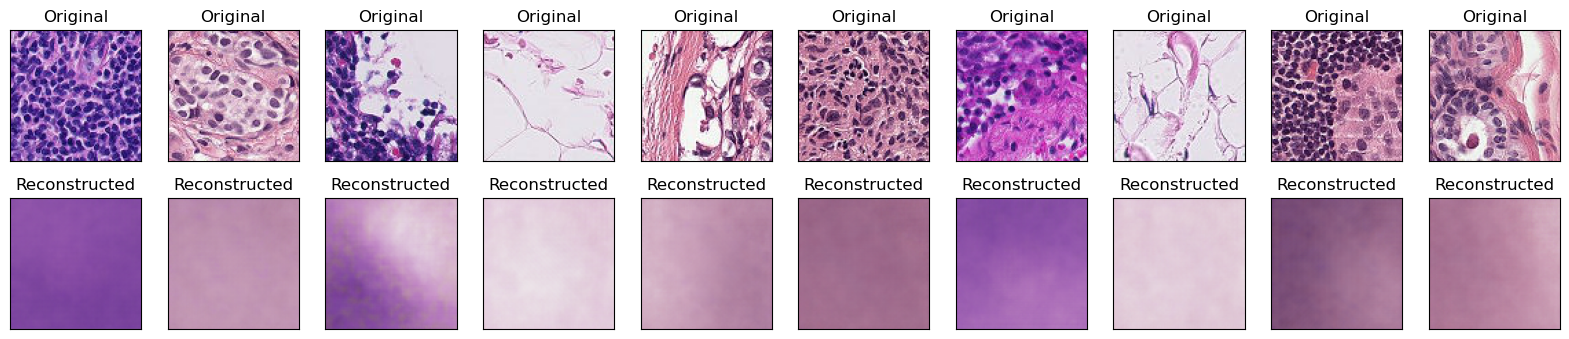

In [52]:
import matplotlib.pyplot as plt
import tensorflow as tf

def compare_vae_reconstructions(vae, test_dataset, num_images=10):
    """
    Fetches examples from the test dataset and compares them with the reconstructed images
    from the Variational Autoencoder (VAE).

    Parameters:
    vae (tf.keras.Model): The trained Variational Autoencoder model.
    test_dataset (tf.data.Dataset): The test dataset.
    num_images (int): Number of images to display.

    """
    # Fetch examples from the test dataset
    samples = next(iter(test_dataset))[0][:num_images]  # Use only input images

    # Generate reconstructed images from the original images
    reconstructed_images = vae.predict(samples)

    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Display original
        ax = plt.subplot(2, num_images, i + 1)
        plt.title("Original")
        plt.imshow(tf.squeeze(samples[i]), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        bx = plt.subplot(2, num_images, i + 1 + num_images)
        plt.title("Reconstructed")
        plt.imshow(tf.squeeze(reconstructed_images[i]), cmap='gray')
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)

    plt.show()

# Usage example (assuming you have a trained VAE model and a test_dataset):
# compare_vae_reconstructions(vae, test_dataset, num_images=10)

compare_vae_reconstructions(vae, test_dataset, num_images=10)